In [1]:
import numpy as np
import matplotlib.pyplot as plt

import yaml

from pyoperators import *
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

import qubic
from qubic.lib.Calibration.Qselfcal import scatter_plot_FP, get_TEScoordinates_ONAFP
from qubic.lib.InstrumentModel.Qinstrument import QubicInstrument
from qubic.lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions
from qubic.lib.MapMaking.Qmaps import InputMaps
from qubic.lib.Qsamplings import get_pointing
%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Nsub_in

In [2]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
        "beam_shape": 'gaussian',
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [3]:
def get_sky_config(params, comm):
        """Sky configuration.

        Method that read 'params.yml' file and create dictionary containing sky emission model.

        Returns
        -------
        dict_sky: dict
            Sky config dictionary.

        Notes
        -----
        Note that the key denote the emission and the value denote the sky model using PySM convention.
        For CMB, seed denote the realization.

        Example
        -------
        d = {'cmb':seed, 'dust':'d0', 'synchrotron':'s0'}

        """

        dict_sky = {}

        if params["CMB"]["cmb"]:
            if params["CMB"]["seed"] == 0:
                if comm.Get_rank() == 0:
                    seed = np.random.randint(10000000)
                else:
                    seed = None
                seed = comm.bcast(seed, root=0)
            else:
                seed = params["CMB"]["seed"]
                
            dict_sky["cmb"] = seed

        for j in params["Foregrounds"]:
            # print(j, params['Foregrounds'][j])
            if j == "Dust":
                if params["Foregrounds"][j]:
                    dict_sky["dust"] = "d0"
            elif j == "Synchrotron":
                if params["Foregrounds"][j]:
                    dict_sky["synchrotron"] = "s0"

        return dict_sky

In [4]:
# Initialize pipeline arguments
comm = MPI.COMM_WORLD

with open('/home/laclavere/Documents/Thesis/qubic/qubic/scripts/Forecast_Bmodes/Nsub input & output/params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [5]:
# Acquisition arguments
dict_qubic = get_dict(params, comm)

nsub_list = np.arange(4, 41, 4)
print(nsub_list)

det_index = 400
sampling_index = 0


[ 4  8 12 16 20 24 28 32 36 40]


In [6]:
sky = get_sky_config(params, comm)
sampling = get_pointing(dict_qubic)
q = QubicInstrument(dict_qubic)

You asked 500 pointings with repeat strategy so I will provide 166 pointings repeated 3 times.


In [7]:
sampling.angle_hwp = sampling.angle_hwp

In [8]:
TOD_list = []
TOD_ones_list = []
for isub in nsub_list:
    print(isub)
    
    TOD = []
    TOD_ones = []
    acq = QubicMultiAcquisitions(dict_qubic, isub, params['QUBIC']['nrec'], sampling=sampling)
    ext = InputMaps(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])
    
    H = acq.H[:int(isub/2)]
    input_maps = ext.m_nu
    input_maps_ones = np.ones(np.shape(input_maps))
    
    for i in range(int(isub/2)):
        C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
        TOD.append(H[i](C(input_maps[i])))
        TOD_ones.append(H[i](C(input_maps_ones[i])))
    TOD_list.append(np.sum(TOD, axis=0))
    TOD_ones_list.append(np.sum(TOD_ones, axis=0))
nsub_list = np.arange(4, int(i/2), 4)

4
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
8
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init

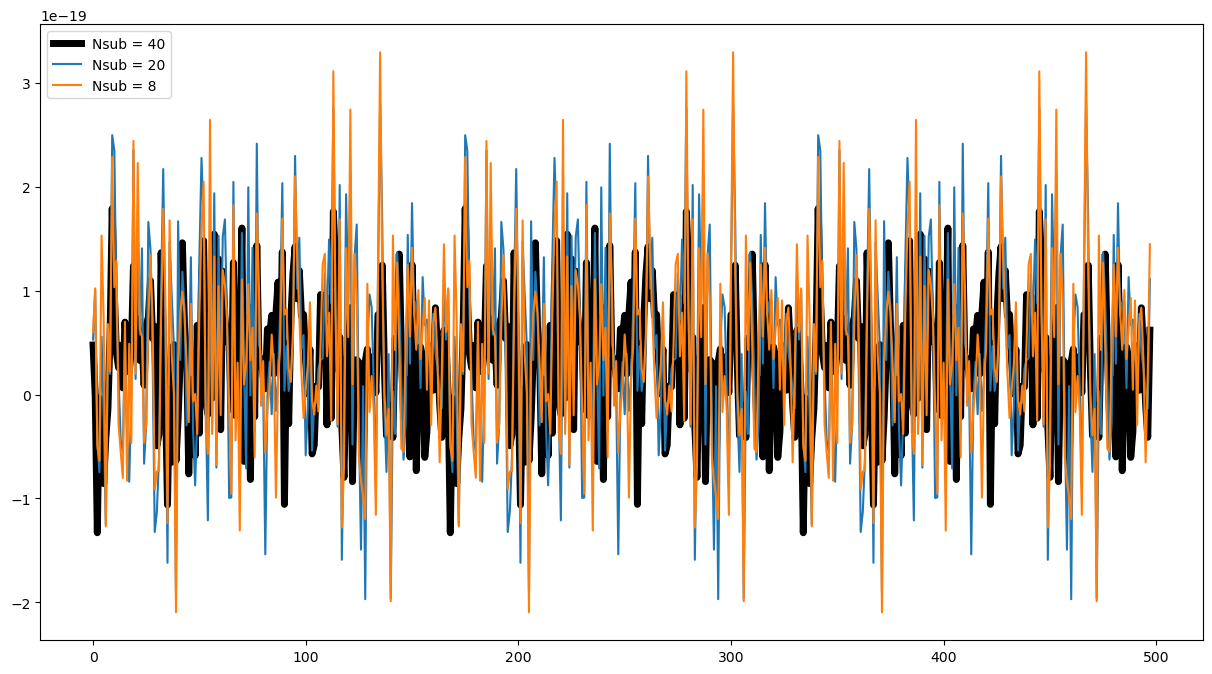

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(sampling.index, TOD[-1][det_index], label=f'Nsub = {nsub_list[-1]}', color='black', lw=5)
#plt.plot(sampling.index, TOD_list[5][det_index], label=f'Nsub = {nsub_list[5]}')
plt.plot(sampling.index, TOD[4][det_index], label=f'Nsub = {nsub_list[4]}')
plt.plot(sampling.index, TOD[1][det_index], label=f'Nsub = {nsub_list[1]}')
#plt.plot(sampling.index, TOD_list[0][det_index], label=f'Nsub = {nsub_list[0]}')
plt.legend()

# Sub-TOD

In [50]:
nsub_max = 40
nsub_list = np.arange(0, nsub_max)

In [42]:
acq = QubicMultiAcquisitions(dict_qubic, nsub_max*2, params['QUBIC']['nrec'], sampling=sampling)
ext = InputMaps(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])

H = acq.H[:nsub_max]
input_maps = ext.m_nu
input_maps_ones = np.ones(np.shape(input_maps))

Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (494016,9) elements = 67.8427734375 MiB in FSRRotation3dMatrix.__init__.


In [47]:
TOD_ones = []
for i in range(nsub_max):
    C = HealpixConvolutionGaussianOperator(0)
    TOD_ones.append(H[i](C(input_maps_ones[i])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.XTick at 0x7844965b2280>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22'),
  Text(24, 0, '24'),
  Text(26, 0, '26'),
  Text(28, 0, '28'),
  Text(30, 0, '30'),
  Text(32, 0, '32'),
  Text(34, 0, '34'),
  Text(36, 0, '36'),
  Text(38, 0, '38')])

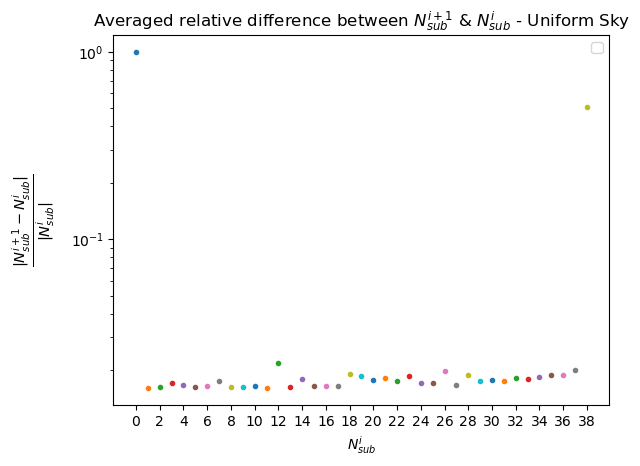

In [51]:
plt.figure()
for i in range(nsub_max-1):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_ones[i+1] - TOD_ones[i])/TOD_ones[i])), '.')
plt.legend()
plt.title(r"Averaged relative difference between $N_{sub}^{i+1}$ & $N_{sub}^i$ - Uniform Sky")
plt.ylabel(r'$\frac{| N_{sub}^{i+1} - N_{sub}^i |}{| N_{sub}^{i} |}$', fontsize=15, labelpad=10)
plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')
plt.xticks(np.arange(0, nsub_max-1, 2))

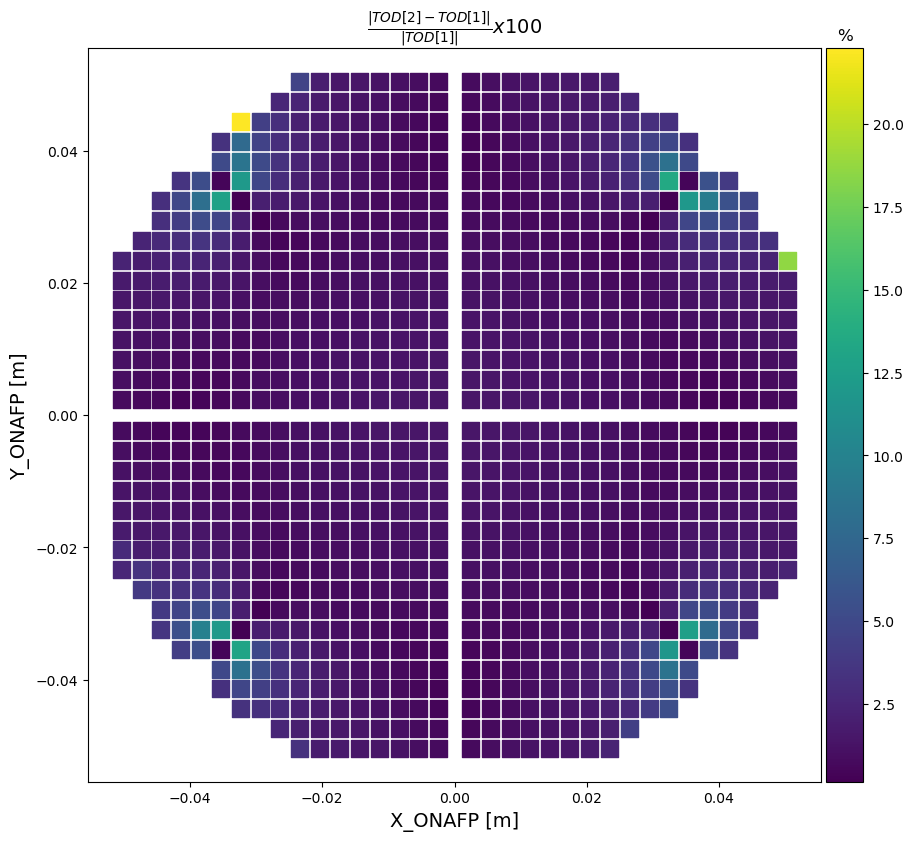

In [49]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_ones[2] - TOD_ones[1]) / np.abs(TOD_ones[1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD[2] - TOD[1] |}{| TOD[1] |} x 100$', fig=fig, ax = ax, unit='%')

# Operators details

## Input Maps

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

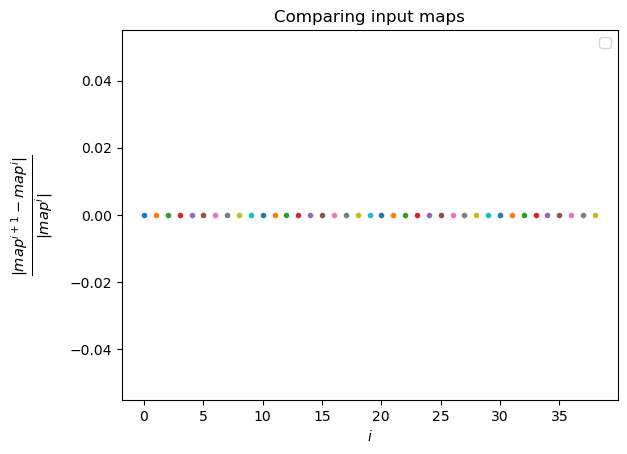

In [64]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((input_maps_ones[i+1,:,0] - input_maps_ones[i,:,0])/input_maps_ones[i,:,0])), '.')
plt.legend()
plt.title(r"Comparing input maps")
plt.ylabel(r'$\frac{| map^{i+1} - map^i |}{| map^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

GOOD

## Convolution operator

In [60]:
test_conv = []
for i in range(nsub_max):
    C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
    test_conv.append(C(input_maps_ones[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

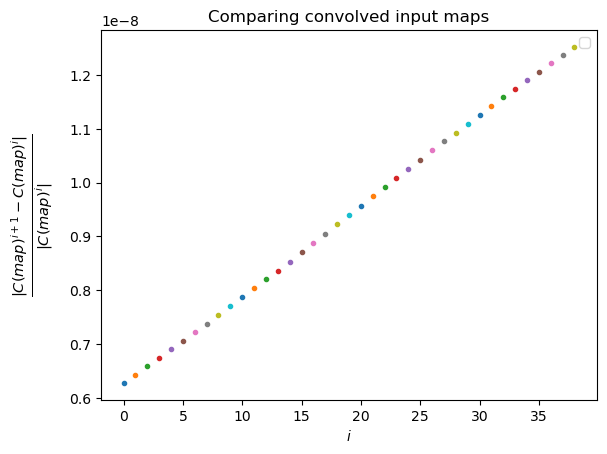

In [66]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_conv[i+1][:,0] - test_conv[i][:,0])/test_conv[i][:,0])), '.')
plt.legend()
plt.title(r"Comparing convolved input maps")
plt.ylabel(r'$\frac{| C(map)^{i+1} - C(map)^i |}{| C(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

OK

## Temperature Operator

In [70]:
test_temp = []
for i in range(nsub_max):
    H_temp_i = H[i].operands[-1]
    C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
    test_temp.append(H_temp_i(C(input_maps_ones[i])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$i$')

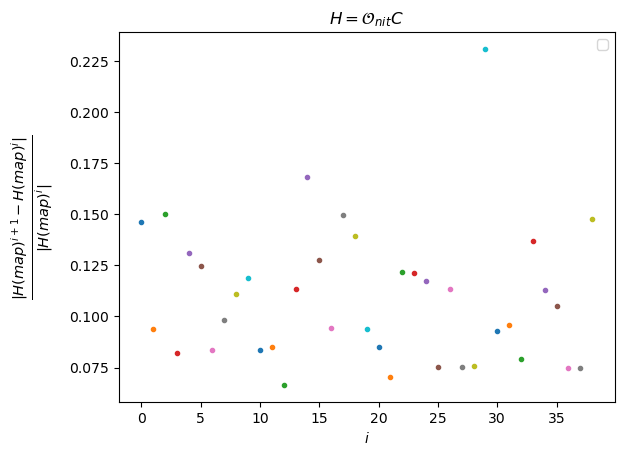

In [77]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i], np.mean(np.abs((test_temp[i+1][:,0] - test_temp[i][:,0])/test_temp[i][:,0])), '.')
plt.legend()
plt.title(r"$H = \mathcal{O}_{nit}C$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$i$')

# CMB

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

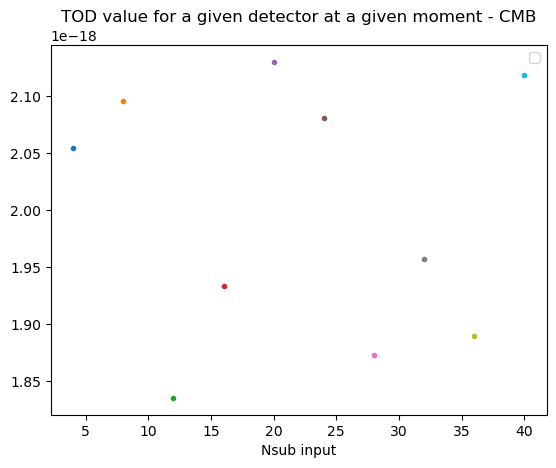

In [13]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], TOD_list[i][det_index][sampling_index], '.')
plt.legend()
plt.title('TOD value for a given detector at a given moment - CMB')
plt.xlabel('Nsub input')

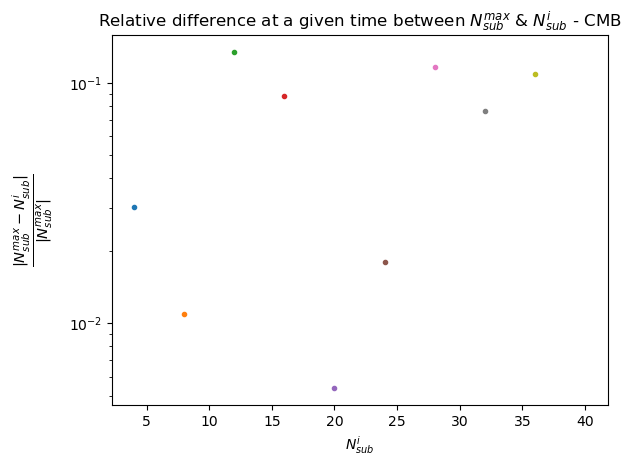

In [14]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.abs((TOD_list[-1][det_index, sampling_index] - TOD_list[i][det_index, sampling_index])/TOD_list[-1][det_index, sampling_index]), '.')
plt.title(r"Relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')
plt.yscale('log')

Text(0.5, 0, '$N_{sub}^i$')

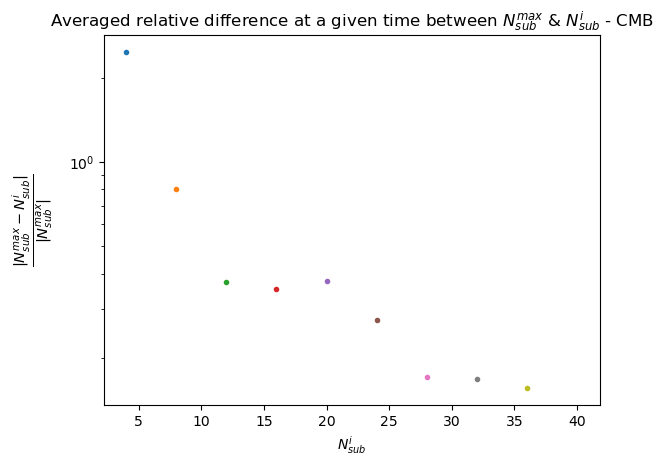

In [15]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_list[-1][:, sampling_index] - TOD_list[i][:, sampling_index])/TOD_list[-1][:, sampling_index])), '.')
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

Text(0.5, 0, '$N_{sub}^i$')

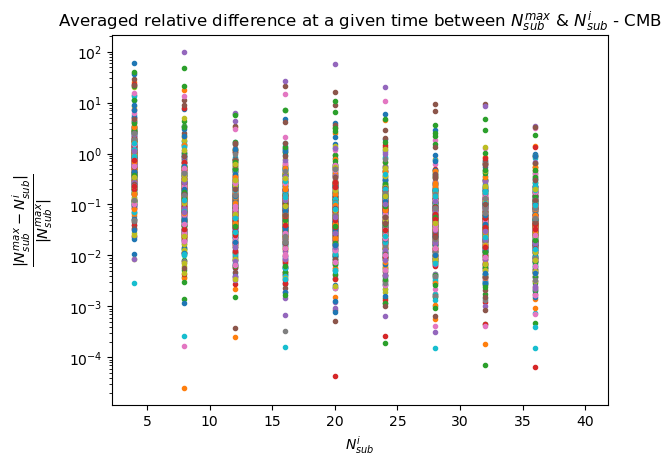

In [16]:
plt.figure()
for i in range(len(nsub_list)):
    for jdet in range(400):
        plt.plot(nsub_list[i], np.abs((TOD_list[-1][jdet, sampling_index] - TOD_list[i][jdet, sampling_index])/TOD_list[-1][jdet, sampling_index]), '.')
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

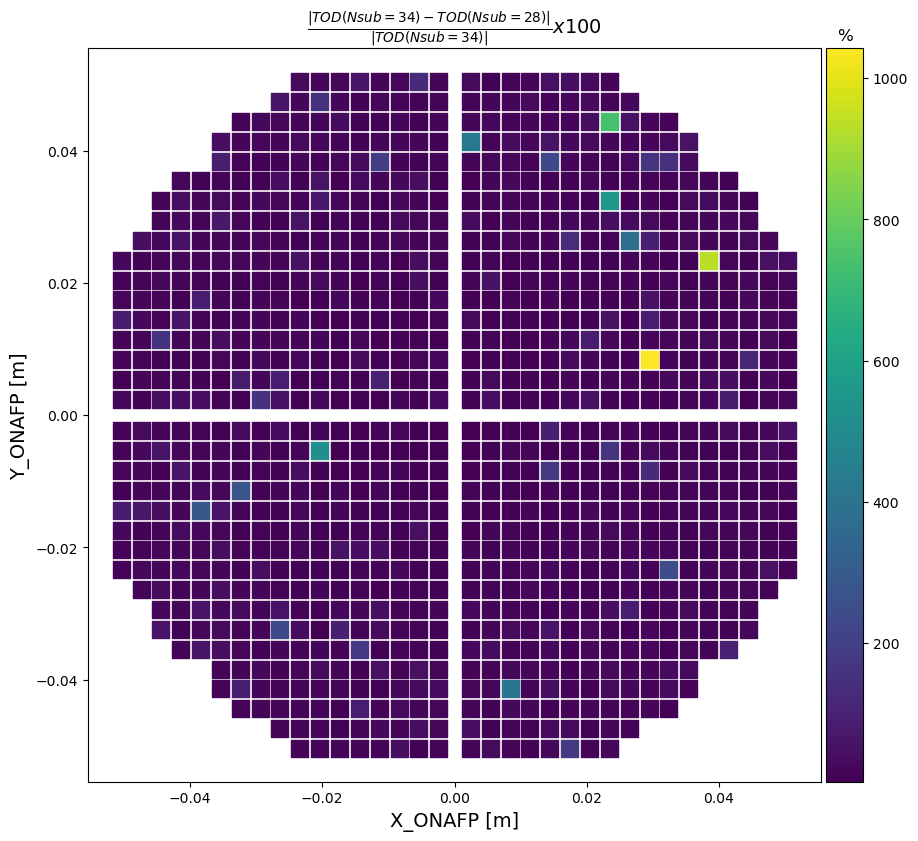

In [17]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_list[-1] - TOD_list[-2]) / np.abs(TOD_list[-1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD(Nsub=34) - TOD(Nsub=28) |}{| TOD(Nsub=34) |} x 100$', fig=fig, ax = ax, unit='%')

Text(0.5, 0, '$N_{sub}^i$')

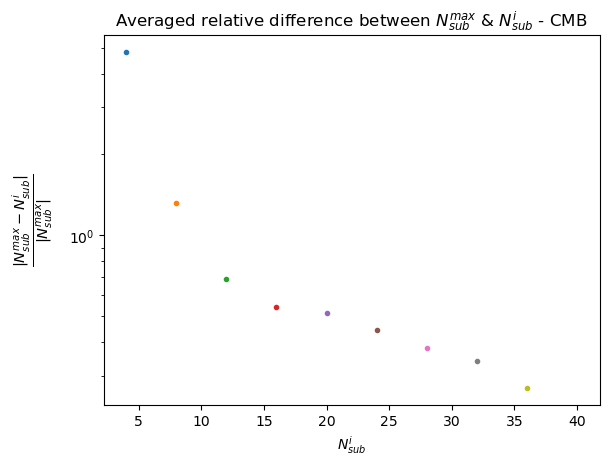

In [18]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.mean(np.abs((TOD_list[-1] - TOD_list[i])/TOD_list[-1]), axis=0)), '.')
plt.title(r"Averaged relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

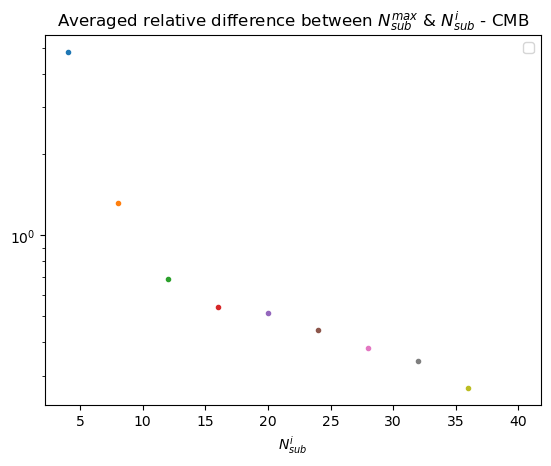

In [19]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_list[-1] - TOD_list[i])/TOD_list[-1])), '.')
plt.legend()
plt.title(r"Averaged relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - CMB")
plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')

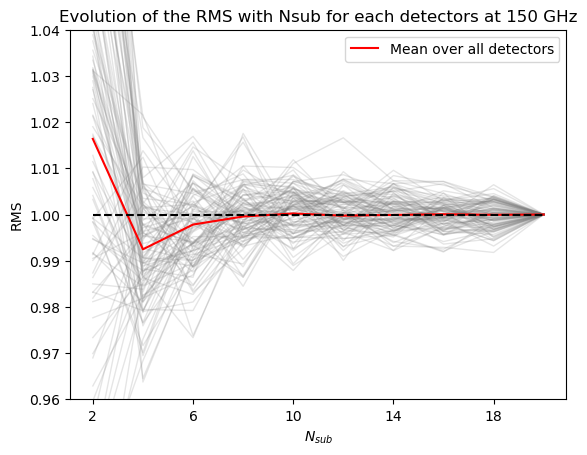

In [20]:
plt.figure()
for idet in range(100):
    plt.plot(nsub_list/2, np.std(TOD_list, axis=2)[:, idet]/np.std(TOD_list, axis=2)[-1, idet], 'grey', alpha=0.2, linewidth=1)
plt.plot(nsub_list/2, np.mean(np.std(TOD_list, axis=2)/np.std(TOD_list, axis=2)[-1], axis=1), 'r', label='Mean over all detectors')
plt.hlines(1, np.min(nsub_list/2), np.max(nsub_list/2), linestyles='--', colors='k')
plt.xlabel(r'$N_{sub}$')
plt.ylabel('RMS')
plt.xticks(nsub_list[::2]/2)
plt.title('Evolution of the RMS with Nsub for each detectors at 150 GHz')
plt.ylim(0.96, 1.04)
plt.legend()

In [21]:
np.std(TOD_list[i][jdet])

1.9384328586762935e-18

# Uniform Sky

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

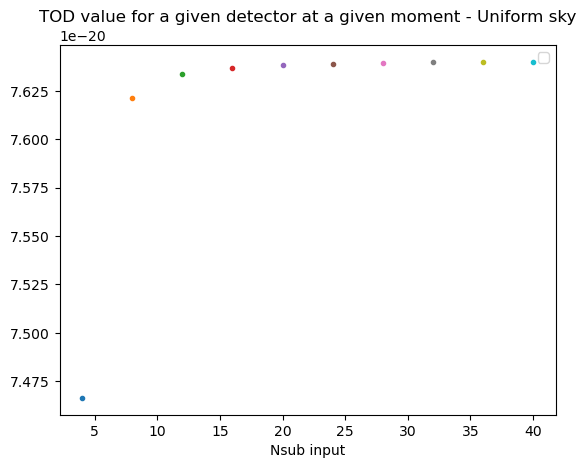

In [22]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], TOD_ones_list[i][det_index][sampling_index], '.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('TOD value for a given detector at a given moment - Uniform sky')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

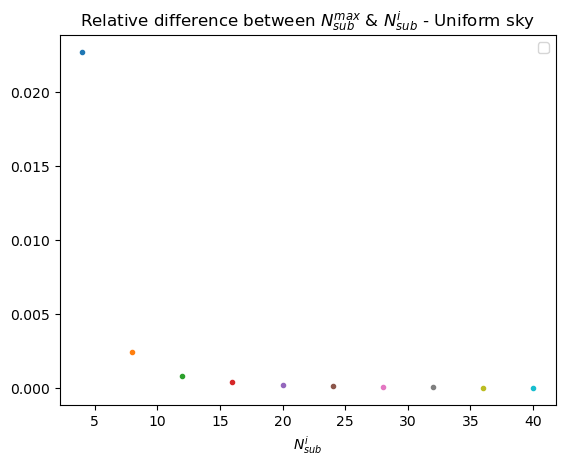

In [23]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.abs((TOD_ones_list[-1][det_index, sampling_index] - TOD_ones_list[i][det_index, sampling_index])/TOD_ones_list[-1][det_index, sampling_index]), '.')
plt.legend()
plt.title(r"Relative difference between $N_{sub}^{max}$ & $N_{sub}^i$ - Uniform sky")
#plt.yscale('log')
plt.xlabel(r'$N_{sub}^i$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$N_{sub}^i$')

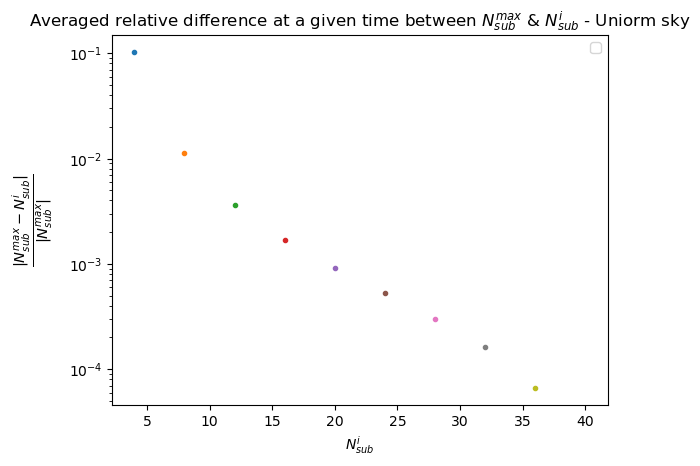

In [24]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(np.abs((TOD_ones_list[-1][:, sampling_index] - TOD_ones_list[i][:, sampling_index])/TOD_ones_list[-1][:, sampling_index])), '.')
plt.legend()
plt.title(r"Averaged relative difference at a given time between $N_{sub}^{max}$ & $N_{sub}^i$ - Uniorm sky")
plt.yscale('log')
plt.ylabel(r'$\frac{| N_{sub}^{max} - N_{sub}^i |}{| N_{sub}^{max} |}$', fontsize=15, labelpad=10)
plt.xlabel(r'$N_{sub}^i$')

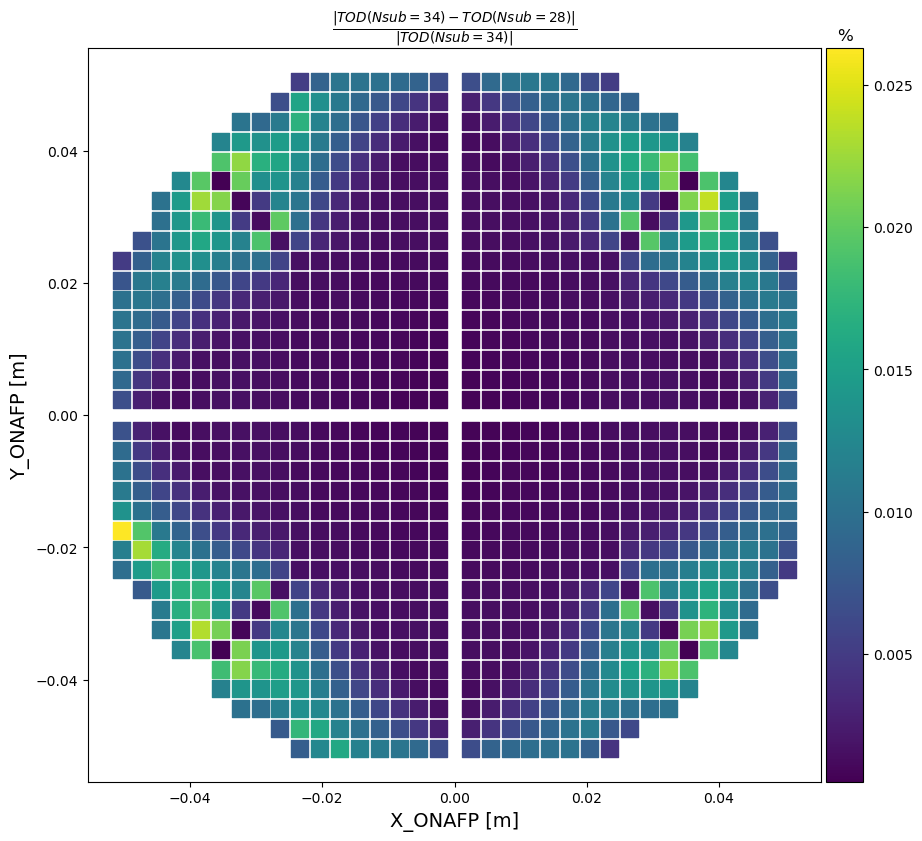

In [25]:
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = np.abs(TOD_ones_list[-1] - TOD_ones_list[-2]) / np.abs(TOD_ones_list[-1]) * 100
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff, axis=1), frame='ONAFP', s=150, title=r'$\frac{| TOD(Nsub=34) - TOD(Nsub=28) |}{| TOD(Nsub=34) |}$', fig=fig, ax = ax, unit='%')

In [26]:
stop

NameError: name 'stop' is not defined